In [1]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
import numpy as np
import cv2
import matplotlib.pyplot as plt

from Non_Maximum_Supression import non_maxi_supression


In [2]:
def selective_search(image):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchQuality()
    
    rects = ss.process()
    
    return rects[:1000]

In [3]:
#model
model = ResNet50(weights = "imagenet")
image = cv2.imread("Resimler/animals.jpg")
image = cv2.resize(image,dsize=(400,400))
(H,W) = image.shape[:2]
    
 

In [4]:
#ss
rects = selective_search(image)
propoals = []
boxes = []
for (x,y,w,h) in rects:
    
    if w/ float(W) < 0.1 or h / float(H) <0.1:
        continue
    roi = image[y:y+h, x:x+w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, (224,224))
    
    roi = img_to_array(roi)
    roi = preprocess_input(roi)

    
    propoals.append(roi)
    boxes.append((x,y,w,h))
    

In [5]:
propoals = np.array(propoals)

#predict
preds = model.predict(propoals)
preds = imagenet_utils.decode_predictions(preds,top=1)

labels = {}
min_conf = 0.9

for (i,p) in enumerate(preds):
    
    (_, label, prob) = p[0]
    
    if prob >= min_conf:
        (x,y,w,h) = boxes[i]
        box = (x,y,x+w,y+h)
        L = labels.get(label,[])
        L.append((box,prob))
        labels[label] = L
        
clone = image.copy()

In [6]:
for label in labels.keys():
    for (box, prob) in labels[label]:
        boxes = np.array([p[0] for p in labels[label]])
        proba = np.array([p[1] for p in labels[label]])
        boxes = non_maxi_supression(boxes,proba)
        
        for (startX, startY, endX, endY) in boxes:
            cv2.rectangle(clone, (startX, startY), (endX, endY), (0,0,255), 3)
            y = startY - 10 if startY -10 > 10 else startY+ 10
            cv2.putText(clone,label,(startX,y),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,255,0),2)
        
cv2.imshow("After",clone)

cv2.waitKey(0)
        
cv2.destroyAllWindows()


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x27d8c86fbb0>)

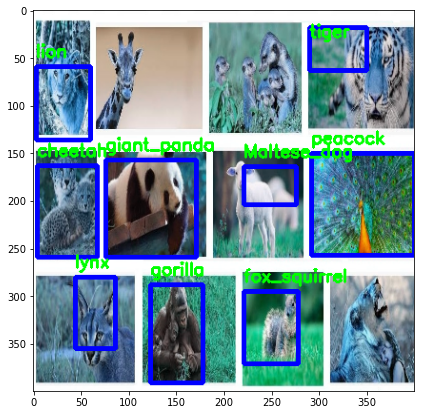

In [13]:
plt.figure(figsize=(7,7)),plt.imshow(clone)